In [1]:
#################################################################################
# This tuitoral performs basic data processing and data analysis for dataset using seurat
# refer to https://satijalab.org/seurat/ Vignette "Guided tutorial"
# Please modify this script to apply for specific dataset.
# Usage: Rscript HCA-d_data_processing_seurat.r datasetName dataFormat
# Usage example: Rscript HCA-d_data_processing_seurat.r spleen_spleen_Madissoon2019 10X
#################################################################################

# args = argsCommand(true)
# datasetName = args[1]
# #datasetName value: organ_tissue_authorYear without space
# dataFormat = args[2]
# #dataFormat value: tsv (tab separated), 10X (sparse)

datasetName = 'Blood_Blood_HCLCord-Blood-CD34P2'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/data1/ljq/jupyter_code/bhyhcad/bhyhcad/hcl_all/Blood_Blood_HCLCord-Blood-CD34P2")
library(Seurat)
library(data.table)
library(ggplot2)
#library(flexclust)
#install.packages('flexclust')

# setwd("/path/to/dataset/")
# library(Seurat)
# library(data.table)
# library(ggplot2)
# library(flexclust)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv.gz"), h = T, row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation_hcad.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation_hcad.tsv"), h = T, sep = "\t", row.names = 1)
}
# Extract demo data for test
#data.matrix <- data.matrix[,1:500]
#data.metadata <- data.metadata[1:500,]
#data.annotation <- data.annotation[1:500,,drop=FALSE]

# Pre-processing
min.cells = 3
min.features = 0
nFeature_RNA_range = c(20, 3000)
percent.mt.thre = 20

# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
if (file.exists(paste0(datasetName,"_annotation_hcad.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}
# QC
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))

# 2. run sctransform 
#dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot
pdf(paste0(datasetName,"seurat.elbowplot.pdf"))
ElbowPlot(dataobj) 
dev.off()

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Centering and scaling data matrix

PC_ 1 
Positive:  FCN1, CTSS, TYROBP, CST3, FCER1G, DUSP1, S100A9, PSAP, LYZ, FTL 
	   S100A12, FOS, JUNB, FTH1, G0S2, S100A8, CSTA, NFKBIA, ZFP36, S100A10 
	   SERPINA1, S100A4, NCF2, S100A6, SAT1, CD14, MS4A6A, SRGN, LGALS1, COTL1 
Negative:  RPS6, RPS3A, RPS18, RPS29, RPS3, RPL3, RPLP0, RPLP1, RPS14, RPL37A 
	   RPS4X, RPS19, RPS12, RPL7, RPS23, RPS27A, RPL32, RPL27A, RPL31, RPL13A 
	   RPS17, RPS25, RPL13, RPL34, RPL15, RPS15A, RPL5, RPS20, RPS27, RPL19 
PC_ 2 
Positive:  AVP, PRSS2, BEX5, ESAM, JCHAIN, MDK, GNG11, MLLT3, PPBP, GKAP1 
	   BEX1, AF064858.8, BAALC-AS2, RP11-354E11.2, LTB, AKR1C3, ZNF528-AS1, ACY3, PF4, MYCT1 
	   CTA-293F17.1, HBD, CCDC102B, ZNF606, KNOP1, TUBB1, SMPD3, GATA2, RRN3P3, FAM19A2 
Negative:  MT-CO1, RPS27, MT-CO3, MT-ND4, TMSB10, MT-ATP6, EEF1A1, B2M, RPL10, MT-ND1 
	   ACTB, RPL30, RPL21, RPS29, RPL27A, MT-CO2, RPLP2, RPLP1, RPL

png 
  2

In [2]:
pcDim = 30 # set as 75 in this case 
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.8, n.start = 10)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11297
Number of edges: 481454

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7469
Number of communities: 11
Elapsed time: 1 seconds


In [3]:
# Visulize the clustering result
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
08:08:04 UMAP embedding parameters a = 0.9922 b = 1.112

08:08:04 Read 11297 rows and found 30 numeric columns

08:08:04 Using Annoy for neighbor search, n_neighbors = 30

08:08:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

08:08:06 Writing NN index file to temp file /tmp/RtmpXJ83qu/fileb8c4d11ca8d

08:08:06 Searching Annoy index using 1 thread, search_k = 3000

08:08:10 Annoy recall = 100%

08:08:10 Commencing smooth kNN distance calibration using 1 thread

08:08:11 Initializing fr

In [4]:
new.cluster.ids<-c('Blood-Connective tissue-Hemopoietic stem cell-SPINK2','Blood-Connective tissue-Hemopoietic stem cell-SPINK2','Blood-Connective tissue-Monocyte-FCN1','Unknown','Blood-Proliferating cell-CNRIP1','Unknown','Blood-Connective tissue-Neutrophil-ELANE MPO','Blood-Connective tissue-Conventional dendritic cell-CD74 HLA-DRA','Blood-Connective tissue-Conventional dendritic cell-CD74 HLA-DRA','Blood-Connective tissue-Hemopoietic stem cell-GAS5')

In [5]:
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)
hcad.label = Idents(dataobj)
dataobj <- AddMetaData(dataobj, metadata = hcad.label,col.name = 'hcad.label')

ERROR: Error in names(new.cluster.ids) <- levels(dataobj): 'names' attribute [11] must be the same length as the vector [9]


In [17]:
write.table(dataobj@meta.data['hcad.label'], file = paste0(datasetName,"_annotation.hcad.label.tsv"), sep = "\t", quote = F, row.names = T, col.names = T)

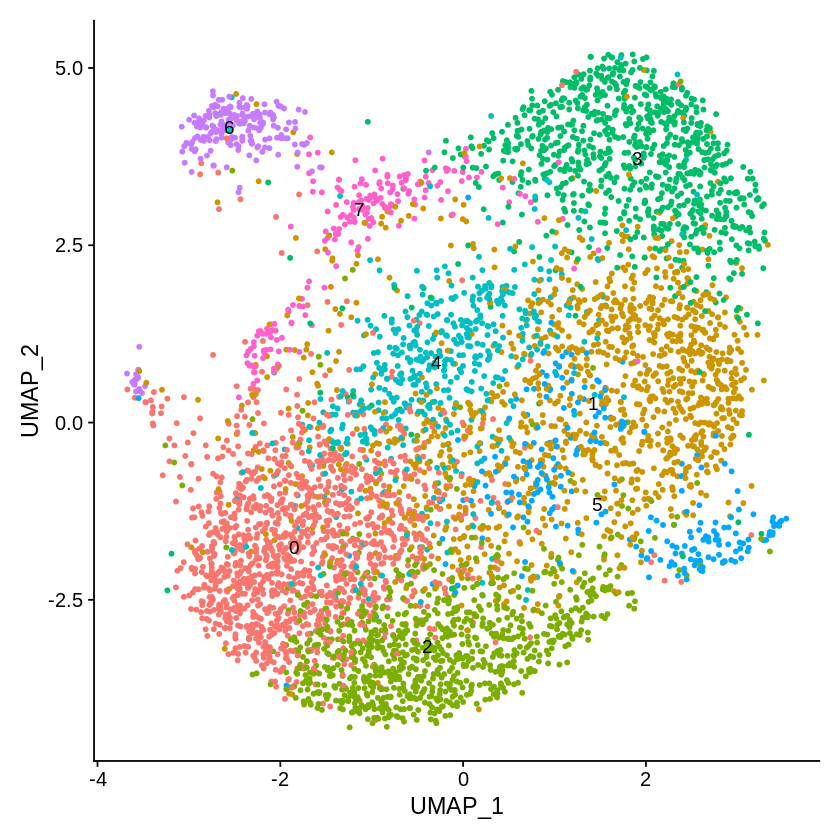

In [4]:
DimPlot(dataobj, reduction = "umap", label = TRUE, pt.size=1)+NoLegend()

In [4]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE, pt.size=1)+NoLegend()
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap, width = 8, height = 5)

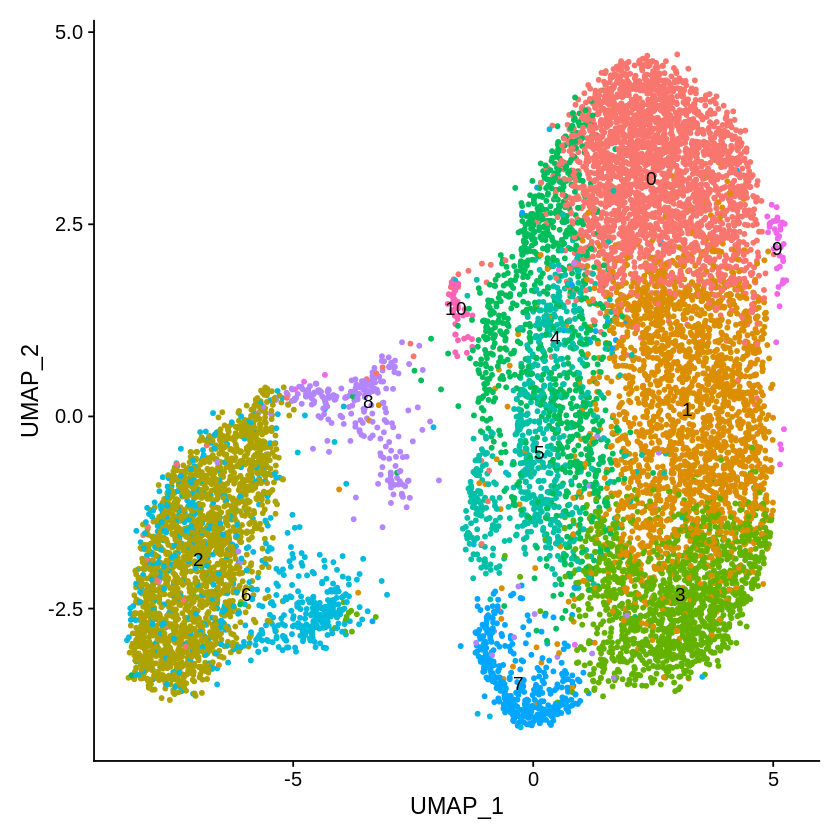

In [5]:
p_umap

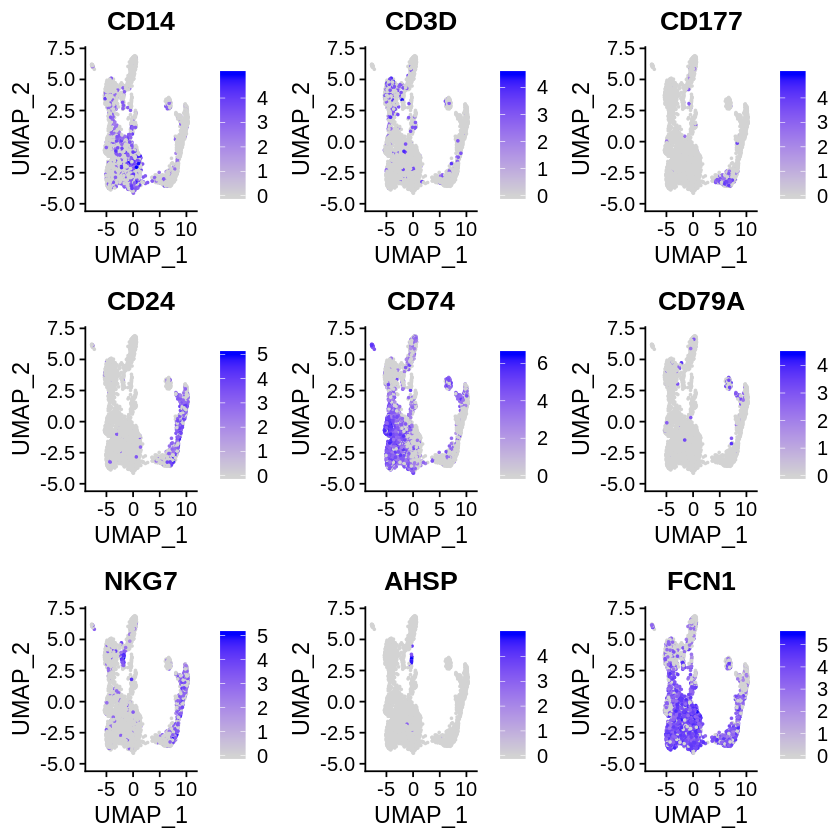

In [20]:
FeaturePlot(dataobj,features = c('CD14','CD3D','CD177','CD24','CD74','CD79A','NKG7','AHSP','FCN1'))

In [25]:
dataobj

An object of class Seurat 
13539 features across 4432 samples within 1 assay 
Active assay: RNA (13539 features)
 2 dimensional reductions calculated: pca, umap

In [14]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cluster.ids", pt.size=1)

ERROR: Error in `[[.Seurat`(object, group.by): Cannot find 'cluster.ids' in this Seurat object


In [21]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1)+NoLegend()
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height =5)

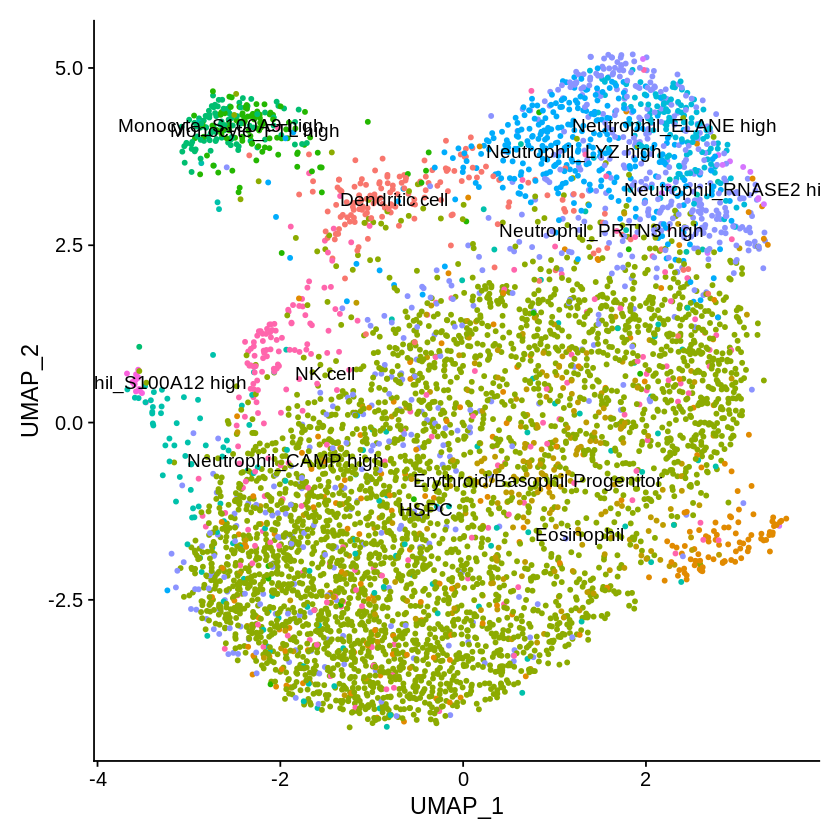

In [22]:
p_umap2

In [8]:
dataobj[['RNA']]@counts[1:5,1:5]

ERROR: Error in eval(expr, envir, enclos): object 'dataobj' not found


In [ ]:
VlnPlot(dataobj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)#+scale_color_npg() 不起作用

In [ ]:
ElbowPlot(dataobj)

In [15]:
# Compare the seurat clusters with original clusters
randIndex(dataobj$cell_cluster,dataobj$seurat_clusters)

ERROR: Error in randIndex(dataobj$cell_cluster, dataobj$seurat_clusters): could not find function "randIndex"


In [6]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1)
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height =5)
if (file.exists(paste0(datasetName,"_annotation_hcad.tsv"))) {
    p_umap3 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_ontology_class", pt.size=1)+NoLegend()
    ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap3, width = 8, height = 5)
}

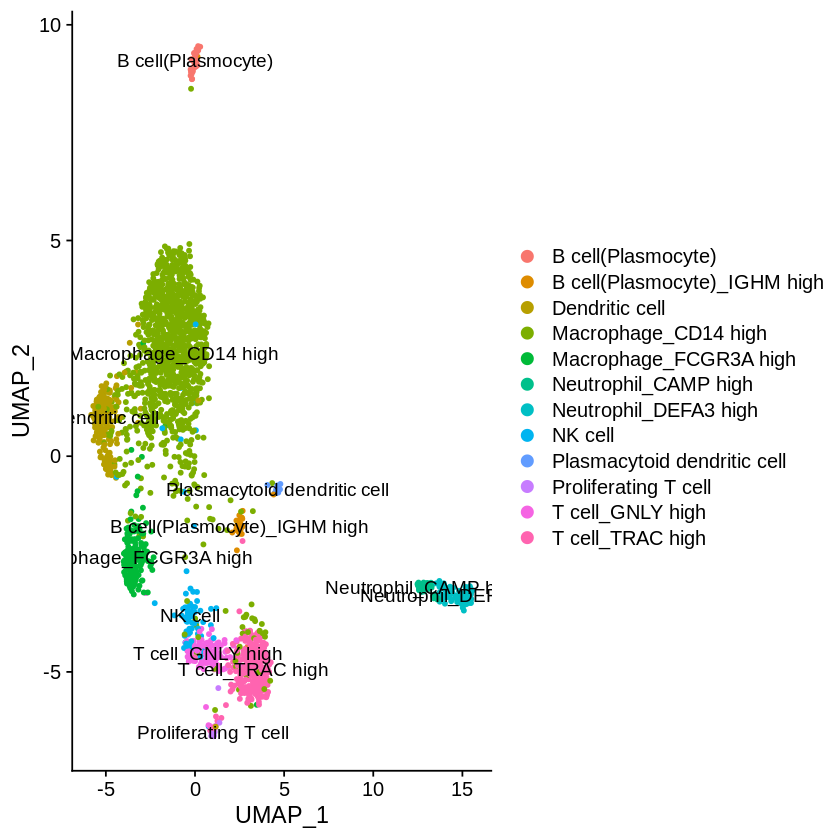

In [7]:
p_umap2

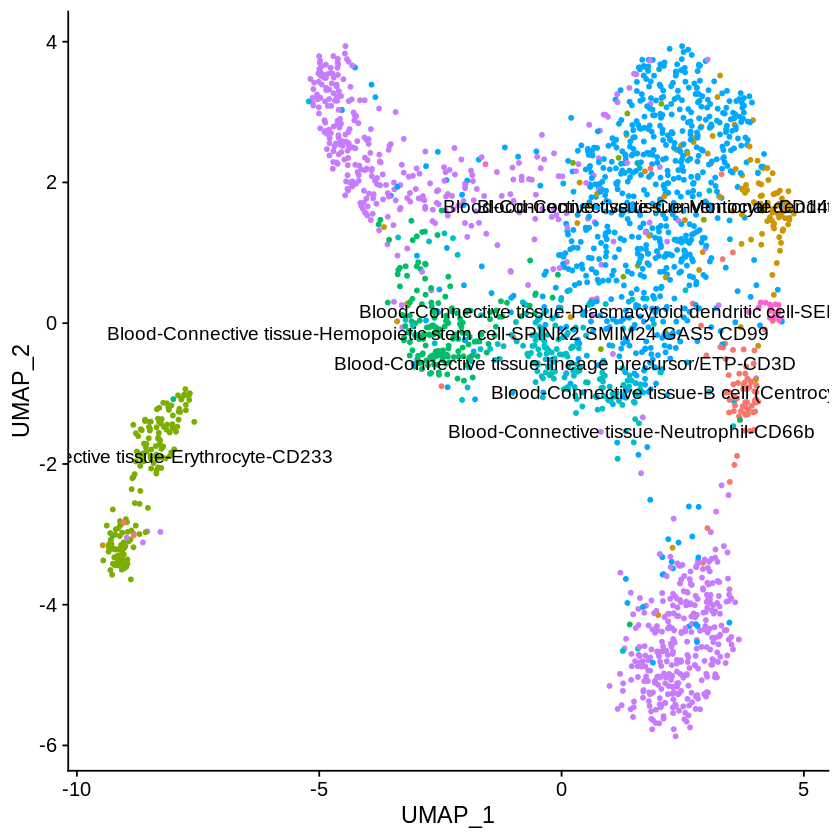

In [7]:
p_umap3

In [18]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

#saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6



In [25]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj22.rds"))

In [45]:
write.table(Idents(dataobj), file = paste0(datasetName,".seurat.annotation_hcad.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

In [15]:
#################################################################################
# This tuitoral performs basic data processing and data analysis for dataset using seurat
# refer to https://satijalab.org/seurat/ Vignette "Guided tutorial"
# Please modify this script to apply for specific dataset.
# Usage: Rscript HCA-d_data_processing_seurat.r datasetName dataFormat
# Usage example: Rscript HCA-d_data_processing_seurat.r spleen_spleen_Madissoon2019 10X
#################################################################################